# UNIVERSIDAD POLITECNICA SALESIANA  

# - SISTEMA DE RECOMENDACION  

## INTEGRANTES: JAVIER YUNGA, JONNATHAN MATUTE 

###  IMPOTAMOS LAS LIBRERIAS  

In [489]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
from subprocess import check_output

print('Librerias importadas')

Librerias importadas


### CARGAMOS EL DATASET MOVIELENS 

In [490]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### VISUALIZAMOS LOS DATOS DE LAS PELICULAS  

In [491]:
# Data de usuarios
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')


# Data de ratings
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

# Data de películas
i_cols = ['movie id', 'movie title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=i_cols,
encoding='latin-1')



print(items.shape)
items.head()


(1682, 24)


,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### VISUALIZAMOS LOS DATOS DE USUARIOS

In [493]:
# Ahora podemos revisar la data
print(users.shape)
users.head()

(943, 5)


,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [494]:
seed = 7
np.random.seed(seed)

x_tr = ratings.drop(['rating'], axis=1)
y_tr = ratings.drop(['user_id','movie_id','unix_timestamp'],axis=1)

### NORMALIZAMOS  

In [495]:
y_tr=np.reshape(y_tr, (-1,1))
y_tr
#Normalización
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x_tr))
xscale=scaler_x.transform(x_tr)
print(scaler_y.fit(y_tr))
yscale=scaler_y.transform(y_tr)

MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))


###  DIVISION EN TRAIN Y TEST

In [496]:
#Split en train y test.
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

###  REALIZAMOS UN PREPROCESAMIENTO PARA CODIFICAR  USUARIOS Y PELICULAS COMO INDICES ENTEROS. 

In [497]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


### SE PREPARA LOS DATOS DE CAPACITACION Y VALIDACION 

In [498]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### CREAMOS EL MODELO CON 50 DIMENSIONES IMPLEMANTANDO LAS METRICAS (MAE, ACC)

In [506]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001), metrics=["mae", "acc"]
)

### ENTRENAMOS EL MODELO CON LA DIVISION DE DATOS. 

In [509]:

import time 
start = time.time()
history = model.fit( 
    x=x_train, 
    y=y_train,
    batch_size=64,
    epochs=5, 
    verbose=1,
    validation_data=(x_val, y_val), )

print("Time finish:",time.time() - start)

Train on 90752 samples, validate on 10084 samples
Epoch 1/5
90752/90752 [==============================] - 10s 106us/sample - loss: 0.6067 - mae: 0.1551 - acc: 0.1355 - val_loss: 0.6139 - val_mae: 0.1636 - val_acc: 0.1322
Epoch 2/5
90752/90752 [==============================] - 9s 102us/sample - loss: 0.6076 - mae: 0.1556 - acc: 0.1351 - val_loss: 0.6119 - val_mae: 0.1608 - val_acc: 0.1321
Epoch 3/5
90752/90752 [==============================] - 9s 104us/sample - loss: 0.6057 - mae: 0.1536 - acc: 0.1358 - val_loss: 0.6125 - val_mae: 0.1614 - val_acc: 0.1313
Epoch 4/5
90752/90752 [==============================] - 10s 109us/sample - loss: 0.6050 - mae: 0.1529 - acc: 0.1361 - val_loss: 0.6103 - val_mae: 0.1576 - val_acc: 0.1308
Epoch 5/5
90752/90752 [==============================] - 9s 104us/sample - loss: 0.6054 - mae: 0.1529 - acc: 0.1361 - val_loss: 0.6113 - val_mae: 0.1591 - val_acc: 0.1311
Time finish: 47.8116352558136


### CALCULAMOS EL ERRO MEDIO DE TRAIN Y TEST 

In [510]:
print("Error medio train", np.mean(history.history["mae"]))
print("Error medio test", np.mean(history.history["val_mae"]))

Error medio train 0.15400998
Error medio test 0.16049014


### CREAMOS LAS GRAFICAS DEL MODELO DE MAE CON LOS EPOCH COMPILADOS ANTERIORMENTE 

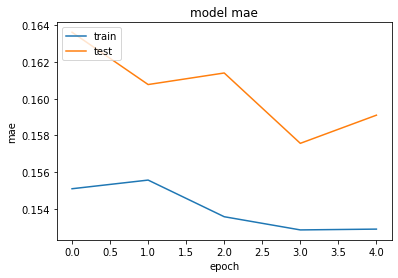

In [511]:
# Graficamos el modelo entrenado con base a los epoch , por medio de train y test
plt.plot(history.history["mae"])
plt.plot(history.history["val_mae"])
plt.title("Modelo MAE")
plt.ylabel("mae")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### CREAMOS LA GRAFICA CON EL ACCURACY OBTENIDO 

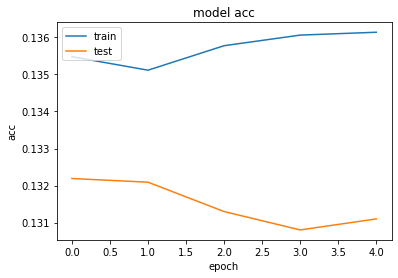

In [512]:
## Grafica de error ACC

plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Modelo Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [513]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]


print("Mostrando recomendaciones para el usuario: {}".format(user_id))
print("====" * 9)
print("Películas con altas calificaciones del usuario")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Las 10 mejores recomendaciones de películas")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

    

Mostrando recomendaciones para el usuario: 242
Películas con altas calificaciones del usuario
--------------------------------
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) : Mystery|Sci-Fi|Thriller
Interview with the Vampire: The Vampire Chronicles (1994) : Drama|Horror
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Quiz Show (1994) : Drama
Silence of the Lambs, The (1991) : Crime|Horror|Thriller
--------------------------------
Las 10 mejores recomendaciones de películas
--------------------------------
Casino (1995) : Crime|Drama
City of Lost Children, The (Cité des enfants perdus, La) (1995) : Adventure|Drama|Fantasy|Mystery|Sci-Fi
Forrest Gump (1994) : Comedy|Drama|Romance|War
His Girl Friday (1940) : Comedy|Romance
Monty Python and the Holy Grail (1975) : Adventure|Comedy|Fantasy
Boondock Saints, The (2000) : Action|Crime|Drama|Thriller
Double Indemnity (1944) : Crime|Drama|Film-Noir
Yi Yi (2000) : Drama
Departed, The (2006) : Crime|Drama|Thriller
Interstellar (2014) : Sci-Fi|IMAX

# Collaborative Filtering

El filtrado colaborativo simplemente utiliza la "sabiduría de la multitud" para recomendar elementos. El filtrado colaborativo basado en elementos utiliza los patrones de los usuarios a los que les gustó la misma película que a mí para recomendarme una película (a los usuarios que les gustó la película que me gusta, a mí también les gustaron estas otras películas). Se realiza una recomendación basada en la entrada del usuario de cualquier película presente en el conjunto de datos.

# RECOMENDACION DE PELICULAS APLICANDO PIVOT 

In [514]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [516]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1')

#u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
#users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols,encoding='latin-1', parse_dates=True) 
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

#r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
#ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,encoding='latin-1')

m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),encoding='latin-1')

movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings, users)

df.head(2)

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076


### Preprocesamiento de datos 

In [517]:
df.drop(df.columns[[3,4,7]], axis=1, inplace=True)
ratings.drop( "unix_timestamp", inplace = True, axis = 1 ) 
movies.drop(movies.columns[[3,4]], inplace = True, axis = 1 )
#Dropping all the columns that are not really needed
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   movie_id      100000 non-null  int64 
 1   title         100000 non-null  object
 2   release_date  99991 non-null   object
 3   user_id       100000 non-null  int64 
 4   rating        100000 non-null  int64 
 5   age           100000 non-null  int64 
 6   sex           100000 non-null  object
 7   occupation    100000 non-null  object
 8   zip_code      100000 non-null  object
dtypes: int64(4), object(5)
memory usage: 7.6+ MB


### Clasificaciones de películas 

In [518]:
movie_stats = df.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

 Establecer un umbral de al menos 50 clasificaciones para un mejor análisis.

In [519]:
min_50 = movie_stats['rating']['size'] >= 50
movie_stats[min_50].sort_values([('rating', 'mean')], ascending=False).head()

rating          
                                                     size      mean
title                                                              
Close Shave, A (1995)                                 112  4.491071
Schindler's List (1993)                               298  4.466443
Wrong Trousers, The (1993)                            118  4.466102
Casablanca (1942)                                     243  4.456790
Wallace & Gromit: The Best of Aardman Animation...     67  4.447761

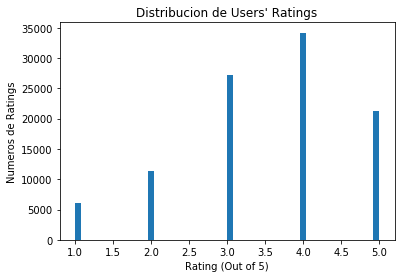

In [541]:
ratings.rating.plot.hist(bins=50)
plt.title("Distribucion de Users' Ratings")
plt.ylabel('Numeros de Ratings')
plt.xlabel('Rating (Out of 5)');

### Distribución de edad de los evaluadores 

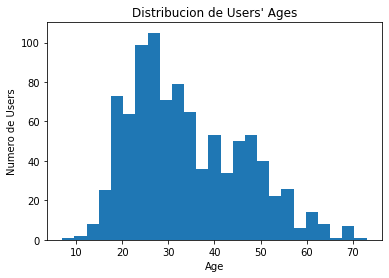

In [540]:
users.age.plot.hist(bins=25)
plt.title("Distribucion de Users' Ages")
plt.ylabel('Numero de Users')
plt.xlabel('Age');

### Pivot Table 

In [522]:
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )
ratings_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Motor de recomendación 

In [524]:
try:
    #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
    user_inp="Speed (1994)"
    inp=movies[movies['title']==user_inp].index.tolist()
    inp=inp[0]
    
    movies['similarity'] = ratings_matrix.iloc[inp]
    movies.columns = ['movie_id', 'title', 'release_date','similarity']
    movies.head(2)
    
except:
    print("Sorry, the movie is not in the database!")

In [525]:
print("Recommended movies based on your choice of ",user_inp ,": \n", movies.sort_values( ["similarity"], ascending = False )[1:10])

Recommended movies based on your choice of  Speed (1994) : 
      movie_id                             title release_date  similarity
705       706                   Bad Moon (1996)  01-Nov-1996         5.0
314       315                  Apt Pupil (1998)  23-Oct-1998         5.0
152       153       Fish Called Wanda, A (1988)  01-Jan-1988         5.0
330       331                  Edge, The (1997)  26-Sep-1997         5.0
344       345       Deconstructing Harry (1997)  01-Jan-1997         5.0
352       353                Deep Rising (1998)  30-Jan-1998         5.0
374       375                  Showgirls (1995)  01-Jan-1995         5.0
379       380     Star Trek: Generations (1994)  01-Jan-1994         5.0
394       395  Robin Hood: Men in Tights (1993)  01-Jan-1993         5.0
